# Modeling the Customer Lifetime Value (CLV)

This section focuses on methodologies that are used to calculate and predict Customer Lifetime Value (CLV). Each model has its unique approach, assumptions, and applications.

1. Aggregate model
2. Cohort model
3. BG/NBD Model (Beta Geometric/Negative Binomial Distribution)
4. Gamma-Gamma Model for predicting CLV.
  
**Moreover, several supervised learning algorithms are also created such as**

1. Linear Regression
2. Lasso Regression
3. Ridge Regression
4. K-Neighbors Regressor
5. Decision Tree Regressor
6. Random Forest Regressor
7. XGBRegressor 
8. CatBoosting Regressor
9. AdaBoost Regressor


## 1. Importing Libraries and Loading data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_clv = pd.read_csv("data_clv.csv")
data_clv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,DayOfWeek,YearMonth,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8,Wednesday,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8,Wednesday,2010-12,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12


**Shape of the dataset**

In [3]:
data_clv.shape

(397884, 13)

**Checking for Null Values**

In [4]:
data_clv.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSales     0
Hour           0
DayOfWeek      0
YearMonth      0
Month          0
dtype: int64

**Check for non-date values or invalid formats**

This code checks for any invalid or non-date values in the 'InvoiceDate' column.

In [5]:
invalid_dates = data_clv[~data_clv['InvoiceDate'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]
print(invalid_dates)


        InvoiceNo StockCode                          Description  Quantity  \
0          536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          536365     71053                  WHITE METAL LANTERN         6   
2          536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3          536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...           ...       ...                                  ...       ...   
397879     581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
397880     581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
397881     581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
397882     581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
397883     581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Coun

In [6]:
# Convert InvoiceDate to datetime, setting errors='coerce' to handle invalid formats
data_clv['InvoiceDate'] = pd.to_datetime(data_clv['InvoiceDate'], errors='coerce')


**Checking the Datatypes**

In [7]:
data_clv.dtypes

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
TotalSales            float64
Hour                    int64
DayOfWeek              object
YearMonth              object
Month                   int64
dtype: object

In [8]:
data_clv.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSales     0
Hour           0
DayOfWeek      0
YearMonth      0
Month          0
dtype: int64

**Printing the details of the dataset**

In [9]:
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


## 2. Modeling the Customer Lifetime Value

### 2.1 Aggregate Model

The simplest and oldest method for calculating CLV is the Aggregate or Average method. This approach assumes that all customers have a constant average spend and churn rate. It doesn't distinguish between individual customers, producing a single CLV value at an overall level. However, this can result in unrealistic estimates, especially if some customers make high-value or high-volume transactions, which can skew the average CLV.

**The General Formula for calculating CLV is:**

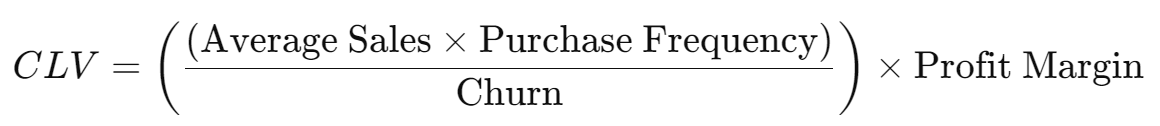

Where:

- **Average Sales** = Total Sales / Total Number of Orders
- **Purchase Frequency** = Total Number of Orders / Total Unique Customers
- **Retention Rate** = (Total Number of Customers with More Than One Order) / (Total Unique Customers)
- **Churn** = 1 - Retention Rate
- **Profit Margin** = Based on business context (assumed to be 5% in this case)

In this instance, the profit margin is assumed to be around 5% for each transaction.

**Transforming data to customer level for the analysis**

In [10]:
data_clv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,DayOfWeek,YearMonth,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8,Wednesday,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8,Wednesday,2010-12,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12


In [11]:
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x:(x.max() - x.min()).days,
                                               'InvoiceNo': lambda x: len(x),
                                               'TotalSales': lambda x:sum(x)})
customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
CustomerID,,,
12346,0,1,77183.60
12347,365,182,4310.00
12348,282,31,1797.24
12349,0,73,1757.55
12350,0,17,334.40


- The `Age` indicates how long the customer has been active.
- The `Frequency` counts the number of unique orders (invoices) for each customer.
- The `TotalSales` shows the total sales for each customer


1. Customer 12347: With an Age of 365 days and a TotalSales of 4,310.00 from 182 orders, this customer has been loyal and consistently engaged with the brand. Their frequent purchases suggest they value the products but might be buying lower-priced items. It could be beneficial to introduce them to higher-value products or loyalty rewards to increase their total sales.
2. Customers 12346, 12349, and 12350: All have an Age of 0 days but different purchasing behaviors.
3. Customer 12346 made a single high-value purchase (77,183.60), which could indicate a potential for being a high-value customer if retained.
4. Customer 12349 shows a surprising frequency of 73 orders despite being a new customer, suggesting they might have a strong interest in certain products. Further engagement can convert them into a loyal customer.
5. Customer 12350, however, has made 17 purchases but with very low total sales (334.40), indicating a need for improvement in their purchasing experience or product offerings.

**Calculating the necessary variables for CLV calculation**

In [12]:
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average Sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']),2)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = round(customer[customer['Frequency'] > 1].shape[0]/customer.shape[0],2)
print(f"Retention Rate: {Retention_rate}")

churn = round(1 - Retention_rate, 2)
print(f"Churn = {churn}%")


Average Sales: $2054.27
Purchase Frequency: 91.72
Retention Rate: 0.98
Churn = 0.02%


**Calculating the CLV**

In [13]:
Profit_margin = 0.05

CLV = round((Average_sales * Purchase_freq/churn) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")

The Customer Lifetime Value (CLV) for each customer is: $471044.11


Our initial model calculated a CLV of `$471K` per customer, which is unrealistic. This result is heavily skewed due to a few customers with extremely high sales, inflating the overall figure. Additionally, it's important to note that not all customers behave the same way.

**Let's check description to understand it**

In [14]:
customer['TotalSales'].describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalSales, dtype: float64

The descriptive statistics show that nearly 75% of customers in our data have sales values below `$2,000`, while the maximum sales value is around `$280K`. Given this, do you think every customer could realistically generate over `$470K` in lifetime value? Definitely not! CLV varies significantly between individual customers or at least across different customer segments, highlighting a key limitation of the Aggregate Model.

### 2.2 Cohort Model

Rather than treating all customers as a single group, we can divide them into multiple groups and calculate CLV for each one. This approach addresses the key limitation of the simple Aggregate model, which assumes all customers are the same. This method is known as the Cohort model.

The key assumption here is that customers within the same cohort have similar spending habits or overall behavior.

A common approach to grouping customers into cohorts is by their start date, usually on a monthly basis. The ideal grouping method depends on factors like the customer acquisition rate, business seasonality, and available customer data.

In this case, I am organizing customers into cohorts based on their start month, resulting in 12 customer cohorts (January to December).

In [15]:
# Transforming the data to customer level for analysis

customer = data_clv.groupby('CustomerID').agg({'InvoiceDate': lambda x: x.min().month,
                                               'InvoiceNo': lambda x: len(x),
                                               'TotalSales': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346,1,1,77183.60
12347,12,182,4310.00
12348,12,31,1797.24
12349,11,73,1757.55
12350,2,17,334.40


In [16]:
customer

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346,1,1,77183.60
12347,12,182,4310.00
12348,12,31,1797.24
12349,11,73,1757.55
12350,2,17,334.40
...,...,...,...
18280,3,10,180.60
18281,6,7,80.82
18282,8,12,178.05


**Customers are grouped based on the month of their first purchase (e.g., customers acquired in January belong to the "January cohort").**

**Grouping customers by 'Start_Month' and calculating the number of customers and their total sales**

In [17]:
customers_per_month_sales = customer.groupby('Start_Month').agg({
    'Frequency': 'size',         # Counts the number of customers in each month (size of the group)
    'TotalSales': 'sum'          # Sums up the total sales of all customers for each month
})

# Renaming columns for clarity
customers_per_month_sales.columns = ['Number_of_Customers', 'TotalSales']

# Displaying the result
print(customers_per_month_sales)


             Number_of_Customers   TotalSales
Start_Month                                  
1                            417  1125882.281
2                            380   593876.880
3                            452   643758.940
4                            300   326621.031
5                            284   455545.380
6                            242   273455.230
7                            188   144468.341
8                            169   196049.050
9                            299   233296.821
10                           358   227369.540
11                           323   151876.730
12                           926  4539207.680


1. `Customer Count Variation:` The number of customers varies significantly across the months. December has the highest number of customers (926), while August has the lowest (169). This suggests that customer acquisition strategies or seasonal factors might influence when customers start transacting.

2. `Total Sales Discrepancies:` December leads significantly in total sales with $4,539,207.68. This indicates that December not only attracted a large volume of customers (926) but also resulted in much higher sales, which could be attributed to holiday shopping trends and promotions.

3. `Decline in Customers and Sales Mid-Year:` There is a noticeable decline in both customer count and total sales from May (284 customers and `$455,545.38`) through August (169 customers and $196,049.05). This may indicate a seasonal dip in engagement or fewer marketing efforts during these months.

4. `Opportunity for Targeted Marketing:` Understanding these cohort patterns provides opportunities for targeted marketing efforts. For example, focusing on re-engaging customers who started in the lower-performing months (like June and July) could help improve overall sales.

5. `Customer Retention Strategies:` The data suggests that certain months might produce more loyal or higher-value customers. By analyzing the behavior and preferences of customers who start in high-sales months (like December), businesses can develop targeted retention strategies to enhance CLV for these segments.

**Calculate CLV for each Cohort**

In [18]:
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346,1,1,77183.60
12347,12,182,4310.00
12348,12,31,1797.24
12349,11,73,1757.55
12350,2,17,334.40


In [19]:
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]

    Average_sales = round(np.mean(customer_m['TotalSales']), 2)

    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)

    Retention_rate = customer_m[customer_m['Frequency'] > 1].shape[0]/customer_m.shape[0]

    churn = round(1 - Retention_rate, 2)

    CLV = round((Average_sales * Purchase_freq/churn) * Profit_margin, 2)

    Monthly_CLV.append(CLV)

In [20]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
display(monthly_clv.style.background_gradient())

,Months,CLV
0,Jan,1546537.090000
1,Feb,313073.920000
2,March,539933.180000
3,Apr,349213.360000
4,May,147597.490000
5,Jun,323795.770000
6,Jul,71760.420000
7,Aug,148834.420000
8,Sep,185155.700000
9,Oct,144042.950000


Upon examining the results, we observe 12 distinct CLV values corresponding to each month from January to December. It is evident that customers acquired in different months have varying CLV values. This variation can be attributed to differences in acquisition campaigns and other factors that may influence customer behavior.

Specifically, the CLV values for January and December are notably high. The data pertains to an online retailer that sells gifts to wholesalers and companies, and both Christmas and New Year occur during these months. This seasonal context explains the elevated CLV for customers who started their transactions in January and December.. 

### 2.3 BG/NBD Model (with Gamma-Gamma extension)

BG/NBD refers to the Beta Geometric/Negative Binomial Distribution.

This model is one of the most widely used probabilistic methods for predicting Customer Lifetime Value (CLV). The BG/NBD aims to forecast the future transactions of individual customers.

This approach is then integrated with the Gamma-Gamma model, which incorporates the monetary value of customer transactions, ultimately allowing us to calculate the Customer Lifetime Value (CLV).

The model essentially fits the distribution to historical data, learning the distribution parameters, which are then used to predict future customer transactions.

We don’t need to handle this complex probabilistic modeling on our own. There is a Python package called **Lifetimes** that simplifies the process. This package is specifically designed to assist with Customer Lifetime Value calculations, customer churn predictions, and more. It includes all the key models and utility functions necessary for CLV calculations.

**Importing the lifetime package**

In [21]:
import lifetimes

First, we need to create a summary table from the transaction data, which is essentially an RFM table (Recency, Frequency, and Monetary value).

To do this, we can utilize the **`summary_data_from_transactions_data`** function from the Lifetimes package. This function aggregates transaction-level data into customer-level insights and calculates the frequency, recency, T, and monetary value for each customer.

- **Frequency**: The number of repeat purchases (i.e., more than one purchase).
- **Recency**: The time elapsed between the first and last transaction.
- **T**: The duration from the first purchase to the end of the transaction period.
- **Monetary Value**: The average sales value for a given customer.


### **Key Difference**:
- **Recency** measures **how recently** a customer has made a purchase, while **T** measures the **total time** the customer has been "active" or part of the dataset.
- In other words, **Recency** is a subset of **T**. Recency focuses on the customer's purchasing activity, while T measures the duration from their first purchase to either the end of the observation period or the last recorded transaction date.

### Example to Clarify

Let's consider an example with a customer transaction history:

| **Transaction Date** | **CustomerID** | **TotalSales** |
|----------------------|----------------|----------------|
| 2023-01-01           | 123            | 100            |
| 2023-02-15           | 123            | 150            |
| 2023-05-20           | 123            | 200            |

- **Observation Period**: Let's say the observation period ends on **2023-12-31**.

- **Recency**:
  - The customer’s first purchase was on **2023-01-01**, and their **last purchase** was on **2023-05-20**.
  - Thus, **Recency** = Time between first and last purchase = `2023-05-20 - 2023-01-01` = **139 days**.

- **T (Customer Age)**:
  - The time between the **first purchase** and the **end of the observation period** (2023-12-31).
  - **T** = Time between first purchase and end of period = `2023-12-31 - 2023-## Additional Perspective
- Recency gives an indication of whether the customer is still actively making purchases or if they have become inactive.
- T provides an understanding of how long the customer has been tracked in the system,Recency Example: If a customer's first purchase was on January 1 and their most recent purchase was on September 1, the recency is the time between these td of the observation period.

**Creating the summary data using summary_data_from_transactions_data**

In [22]:
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID', 'InvoiceDate', 'TotalSales')
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,0.0,0.0,325.0,0.000000
1,12347,6.0,365.0,367.0,599.701667
2,12348,3.0,283.0,358.0,301.480000
3,12349,0.0,0.0,18.0,0.000000
4,12350,0.0,0.0,310.0,0.000000


In [23]:
print(summary['frequency'].min())
print(summary['frequency'].max())

0.0
131.0


**Here, the value of 0 in frequency and recency means that these are one time buyers. Let's check how many such one time buyers are there in the data.**

count    4338.000000
mean        2.864223
std         5.949000
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
----------------------------------------------
Percentage of customers purchase the item only once: 35.68%


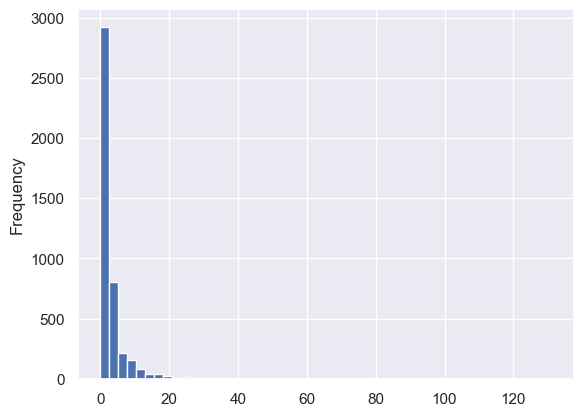

In [24]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("----------------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0) / float(len(summary))*(100),2)
print(f"Percentage of customers purchase the item only once: {one_time_buyers}%")

**Now, let's fit the BG/NBD model to our summary data.**

BG/NBD model is available as BetaGeoFitter class in lifetimes package.

In [25]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

In [26]:
#model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


The table above presents the estimated distribution parameter values derived from historical data. The model utilizes these parameters to predict future transactions and assess customer churn rates.

If you want to determine whether a customer is currently active (or predict customer churn) based on historical data, the Lifetimes package offers a solution:

- **`model.conditional_probability_alive()`**: This method calculates the probability that a customer with specific history (frequency, recency, T) is still active.
- **`plot_probability_alive_matrix(model)`**: This function from the Lifetimes plotting module allows for a visual analysis of the relationship between recency, frequency, and the likelihood of a customer being active.

In [27]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346,0.0,0.0,325.0,0.000000,1.000000
1,12347,6.0,365.0,367.0,599.701667,0.999698
2,12348,3.0,283.0,358.0,301.480000,0.999177
3,12349,0.0,0.0,18.0,0.000000,1.000000
4,12350,0.0,0.0,310.0,0.000000,1.000000
5,12352,6.0,260.0,296.0,368.256667,0.999406
6,12353,0.0,0.0,204.0,0.000000,1.000000
7,12354,0.0,0.0,232.0,0.000000,1.000000
8,12355,0.0,0.0,214.0,0.000000,1.000000
9,12356,2.0,303.0,325.0,269.905000,0.999478


- **Customer 12346**:
  - This customer has `0.0` frequency, `0.0` recency, and `325` days as the customer age (`T`).
  - This means that they made only a single purchase at the very beginning of the observation period and have not made any repeat purchases.
  - Their probability of being alive is `1.000000`, meaning the model believes that since the customer made no repeat purchases, they are still "alive."

- **Customer 12347**:
  - This customer has `6.0` frequency, `365.0` recency, and `367` days as customer age (`T`).
  - This means they made 6 repeat purchases, and their last purchase was very close to the end of the observation period.
  - The probability of being alive is `0.999698`, which is very high, indicating that this customer is highly likely to make future purchases.

- **Customer 12348**:
  - This customer has `3.0` frequency, `283.0` recency, and `358` days as customer age (`T`).
  - This means they made 3 repeat purchases, and the last purchase was made approximately 75 days before the end of the observation period.
  - The probability of being alive is `0.999177`, which is still very high.

- **Customer 12349**:
  - This customer has `0.0` frequency, `0.0` recency, and `18` days as customer age (`T`).
  - They made only a single purchase at the very beginning of their customer age, but since `T` is low, the model assumes they are still active.
  - Probability of being alive is `1.000000`.

- **Customer 12350**:
  - This customer has `0.0` frequency, `0.0` recency, and `310` days as customer age (`T`).
  - Similar to customer 12346, this customer made no repeat purchases, but due to the long period (`T`), the model still assumes they are alive with a probability of `1.000000`.

**Insights**
- **High `probability_alive` values** suggest customers are likely to continue making purchases, indicating a strong customer relationship or recent purchase activity.
- **Low `probability_alive` values** suggest that customers are likely inactive or have churned, and the company may consider re-engagement strategies.


- If `monetary_value` is `0.0`, it means that this customer's purchase value was either not captured correctly or was zero due to some issue in the dataset.
   - This may occur because:
     - There were data entry issues.
     - There were returns or cancellations that resulted in a net zero sales value.
       

Because of these factors, the BG/NBD model outputs a `probability_alive` of `1.0` since the customer hasn't shown any signs of churn based on the data provided.



### **Next thing we can do with this trained model is to predict the likely future transactions for each customer.**

model.conditional_expected_number_of_purchases_up_to_time(): Calculate the expected number of repeat purchases up to time `t` for a randomly chosen indvidual from a population (or the whole population), given they have purchase history(frequency, recency, T).

In [29]:
# Predict future transactions for the next 30 days based on the historical data
t = 30 #10
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']), 2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1879,14911,131.0,372.0,373.0,1093.661679,0.999966,8.95
1,326,12748,112.0,373.0,373.0,301.024821,0.999971,7.66
2,4010,17841,111.0,372.0,373.0,364.452162,0.999962,7.59
3,2176,15311,89.0,373.0,373.0,677.729438,0.999964,6.10
4,1661,14606,88.0,372.0,373.0,135.890114,0.999955,6.03
5,481,12971,70.0,369.0,372.0,159.211286,0.999926,4.82
6,562,13089,65.0,367.0,369.0,893.714308,0.999934,4.51
7,1602,14527,53.0,367.0,369.0,155.016415,0.999925,3.69
8,1069,13798,52.0,371.0,372.0,706.650962,0.999933,3.59
9,2990,16422,47.0,352.0,369.0,702.472340,0.999567,3.27


We now have a prediction for the number of purchases a customer will make in the next 10 days.

To verify whether the predicted number is reasonable, we can perform a quick check:

For Customer ID 14911, over 372 days, they made 131 purchases. This means they make approximately 131/372 = 0.352 purchases per day. Therefore, for 10 days, the expected number of purchases would be 3.52.

Our predicted result is 8.95, which is fairly close to the manual probability estimate we calculated earlier. The discrepancy arises from various assumptions about customers, such as dropout rates and modeling customer lifetime as an exponential distribution.

Now that we have predicted the expected future transactions, we need to estimate the future monetary value of each transaction.

As mentioned earlier, the BG/NBD model is limited to predicting a customer’s future transactions and churn rate. To incorporate the monetary aspect of the problem, we need to model the transaction value using the Gamma-Gamma Model.

### 2.4 **Gamma-Gamma Model**

The Gamma-Gamma model is employed in Customer Lifetime Value (CLV) prediction to estimate the monetary value of customer transactions over time. It operates under several important assumptions that simplify the modeling process, though these assumptions must be understood clearly.

1. The value of a customer’s transaction fluctuates randomly around their average transaction value.
2. While average transaction values differ between customers, they remain consistent over time for any individual customer.
3. The distribution of average transaction values across customers is independent of their transaction frequency.

Here’s a detailed explanation of each of these assumptions, with examples:

#### 1. **The value of a customer’s transaction fluctuates randomly around their average transaction value.**

#### Explanation:
- This assumption means that while a customer may not spend exactly the same amount on every transaction, their spending is **centered around an average value**. The specific amount spent on any single transaction fluctuates, but these fluctuations are assumed to be random and not systematically biased.
- For instance, if a customer usually spends **USD100 per transaction**, the amounts they actually spend may vary from, say, **USD90, USD110, USD95**, etc. The Gamma-Gamma model assumes that these values fluctuate around the customer's **average transaction value** (in this case, USD100).

#### Example:
- **Customer A** typically spends an average of **USD50** on purchases. Sometimes they may spend **USD45**, and other times they may spend **USD55**. Over time, these variations average out to about $50.
- **Customer B** typically spends an average of **USD200**. While their transaction amounts might fluctuate between **USD190 and USD210**, they also cluster around their personal average value of USD200.
  
This assumption essentially models the **randomness** of spending behavior, meaning we do not expect customers to spend exactly the same amount in every transaction, but we expect the amounts to be reasonably close to their own average.

---

#### 2. **While average transaction values differ between customers, they remain consistent over time for any individual customer.**

#### Explanation:
- This assumption suggests that while customers have different **average spending behaviors**, each individual customer’s **average spending remains stable** over time. The model assumes that if a customer spends an average of USD100 per transaction today, they will continue to spend that same average amount over their lifetime.
  
- The model allows for significant **variability between customers**, but not within a single customer's behavior over time. For example, **Customer A** might have a lower average spending amount (e.g., USD50), while **Customer B** might have a higher average (e.g., USD200), but each customer’s average transaction value is assumed to remain consistent.

#### Example:
- **Customer A**: Has a stable pattern of spending around **USD50 per transaction**. Even if they make purchases a year from now, their average transaction value is expected to remain near $50.
  
- **Customer B**: Has an average transaction value of **USD200**. Whether they shop today or six months later, their average transaction value will likely remain at USD200.

This assumption simplifies the modeling by making it easier to estimate a customer’s **lifetime value** because the average spending behavior is treated as a stable characteristic over time.

---

#### 3. **The distribution of average transaction values across customers is independent of their transaction frequency.**

#### Explanation:
- This assumption implies that the **frequency of transactions** (how often a customer buys) and the **monetary value of each transaction** are not related to each other. In other words, a customer's transaction frequency does not give any information about their **average transaction value**.

- The Gamma-Gamma model assumes that just because one customer shops more frequently, it doesn’t mean they will spend more or less per transaction compared to someone who shops less often. Therefore, the two processes (how often a customer buys and how much they spend) are **independent** of each other.

#### Example:
- **Customer A** might buy frequently, say **10 times a month**, but their **average transaction value** may be only **$20**.
- **Customer B** might buy less frequently, say only **twice a month**, but they spend **USD200** per transaction.

In this example, while **Customer A** buys more often, they spend less on each purchase. **Customer B** spends more but buys less frequently. The **transaction frequency** (how often they buy) does not influence their **average transaction value** (how much they spend).

The model assumes that customers who buy often may still have low or high average transaction values, just like customers who buy rarely may have any average transaction value. The two variables are **independent**.

---

#### Summary of Assumptions with Examples:

1. **Transaction values fluctuate randomly around a customer's average**: A customer who usually spends USD100 may spend USD95 today and USD105 tomorrow, but it will balance out around their personal average.
  
2. **Average transaction value varies across customers but is stable for each customer**: Each customer has their own average spending (e.g., Customer A spends USD50, Customer B spends USD200), and this amount remains consistent over time.
  
3. **Transaction frequency is independent of average transaction value**: How often a customer buys does not influence how much they spend per transaction. Frequent buyers may spend more or less per purchase, and infrequent buyers could also spend more or less per transaction, independently of their purchase frequency.

These assumptions make it easier to model CLV, as the Gamma-Gamma model focuses on the stability of spending behavior over time for each customer and treats transaction frequency separately from transaction value.

As a first step before fitting the model to the data, we have to check whether the assumptions made by the model holds good for the data. Only if it satisfies, we have proceed further.

Out of the three, the final assumption can be validated. What it means is that, there is no relationship between frequency and monetary value of transactions. This can be easily validated using Pearson correlation.

NOTE: We are considering only customers who made repeat purchases with the business i.e., frequency > 0. Because, if frequency is 0, it means that they are one time customer and are considered already dead.

In [30]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency'] > 0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2790, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25


In [31]:
# Checking the relationship between frequency and monetary value
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


The correlation appears to be very weak. Therefore, we can conclude that the assumption holds, and the model can be applied to our data.

**Modelling the monetary value using Gamma-Gamma Model**

In [32]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
        return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [33]:
# summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125568,0.269274,10.597792,11.653344
q,0.838782,0.019731,0.800110,0.877455
v,11.292978,0.281539,10.741162,11.844795


Next, we can use the model to estimate the expected average profit per transaction and predict the Customer Lifetime Value.

- model.conditional_expected_average_profit(): This model computes the conditional expectation of the average profit per transaction for a group of one or more customers.


In [34]:
# Calculating the conditional expected average profit for each customer per transaction
summary.head()


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,12346,0.0,0.0,325.0,0.000000,1.000000,0.06
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27
3,12349,0.0,0.0,18.0,0.000000,1.000000,0.29
4,12350,0.0,0.0,310.0,0.000000,1.000000,0.07


In [35]:
summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                                                   summary['monetary_value'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


**Note:** I refer to "expected average sales" because the monetary value we're using represents the actual sales amount, not profit. By following the method above, we calculate the average sales, and then we can multiply the result by the profit margin to obtain the actual profit value.

In [36]:
# checking the expected average value and the actual average value in the data to make sure the values are good.
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 486.90902215126687
Actual Average Sales: 477.3803385139514


The values look reasonable. Now, let’s calculate the Customer Lifetime Value directly using the method from the Lifetimes package.

Here are three key points to keep in mind:

- **time**: In the `customer_lifetime_value()` method, this parameter is measured in months. For example, `t=1` represents one month, and so on.
- **freq**: This specifies the time unit of your data. If your data is at a daily level, use "D"; if it's monthly, use "M," etc.
- **discount_rate**: This is based on the Discounted Cash Flow (DCF) concept, where you apply a discount rate to future monetary values to calculate their present value. The default rate in the documentation is 0.01, which corresponds to 12.7% annually.

In [37]:
# Predicting the customer lifetime value for the next 30 days
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                       summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time = 1, # lifetime in months
                                                       freq = 'D', # frequency in which the data is present(T)
                                                       discount_rate=0.01) # discount rate
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478


CLV can be manually calculated by multiplying the predicted number of future transactions (pred_num_txn) with the expected average sales per transaction (exp_avg_sales).

In [38]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170


Both the CLV values are very close to each other and seems reasonable for the next 30 days.

One thing to note here is that, both the values we have calculated for CLV is the sales value, not the actual profit. To get the net profit for each customer, we can either create profit value in the beginning by multiplying sales value with profit margin or we can do that now.



In [39]:
# CLV in terms of profit(profit margin is 5%)
profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916,14.020476
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990,4.079551
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558,10.301732
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757,2.956265
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170,8.727524


In [40]:
# Distribution of CLV for the business in the next 30 days
summary['CLV'].describe()

count    2790.000000
mean       12.312040
std        49.327361
min         0.136205
25%         2.826065
50%         5.668581
75%        10.967735
max      1692.149403
Name: CLV, dtype: float64

Finally, we predicted the CLV for each customers for the next 30 days.

The marketing team can now use this information to target customers and increase their sales.

## 3. Machine Learning Models

### 3.1 Checking the data and selecting important features

In [41]:
data_clv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,DayOfWeek,YearMonth,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8,Wednesday,2010-12,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8,Wednesday,2010-12,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,Wednesday,2010-12,12


In [42]:
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916,14.020476
2,12348,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990,4.079551
5,12352,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558,10.301732
9,12356,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757,2.956265
11,12358,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170,8.727524


In [43]:
merged_df = pd.merge(data_clv, summary, on='CustomerID', how='inner')
merged_df.shape

(361882, 23)

In [44]:
merged_df.isnull().sum()

InvoiceNo               0
StockCode               0
Description             0
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID              0
Country                 0
TotalSales              0
Hour                    0
DayOfWeek               0
YearMonth               0
Month                   0
frequency               0
recency                 0
T                       0
monetary_value          0
probability_alive       0
pred_num_txn            0
exp_avg_sales           0
predicted_clv           0
manual_predicted_clv    0
CLV                     0
dtype: int64

**There are no null values in the dataset**

In [45]:
merged_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,...,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8,...,1.0,1.0,373.0,3891.87,0.985426,0.12,3960.554386,479.139496,475.266526,23.956975
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,...,1.0,1.0,373.0,3891.87,0.985426,0.12,3960.554386,479.139496,475.266526,23.956975


In [46]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361882 entries, 0 to 361881
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   InvoiceNo             361882 non-null  int64         
 1   StockCode             361882 non-null  object        
 2   Description           361882 non-null  object        
 3   Quantity              361882 non-null  int64         
 4   InvoiceDate           361882 non-null  datetime64[ns]
 5   UnitPrice             361882 non-null  float64       
 6   CustomerID            361882 non-null  int64         
 7   Country               361882 non-null  object        
 8   TotalSales            361882 non-null  float64       
 9   Hour                  361882 non-null  int64         
 10  DayOfWeek             361882 non-null  object        
 11  YearMonth             361882 non-null  object        
 12  Month                 361882 non-null  int64         
 13 

**Creating a new dataframe with columns such as CustomerID','Description','Country','frequency','recency','T','monetary_value','CLV'**

In [47]:
df = merged_df[['CustomerID','Description','Country','frequency','recency','T','monetary_value','CLV']]
df.head()

,CustomerID,Description,Country,frequency,recency,T,monetary_value,CLV
0,17850,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
1,17850,WHITE METAL LANTERN,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
2,17850,CREAM CUPID HEARTS COAT HANGER,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
3,17850,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
4,17850,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,1.0,1.0,373.0,3891.87,23.956975


In [48]:
df = df.rename(columns={'T':'Time'})
df.head()

,CustomerID,Description,Country,frequency,recency,Time,monetary_value,CLV
0,17850,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
1,17850,WHITE METAL LANTERN,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
2,17850,CREAM CUPID HEARTS COAT HANGER,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
3,17850,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
4,17850,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,1.0,1.0,373.0,3891.87,23.956975


In [49]:
df['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    1854
REGENCY CAKESTAND 3 TIER              1571
JUMBO BAG RED RETROSPOT               1538
ASSORTED COLOUR BIRD ORNAMENT         1285
PARTY BUNTING                         1285
                                      ... 
BIG POLKADOT MUG                         1
PINK POLKADOT KIDS BAG                   1
AMETHYST DIAMANTE EXPANDABLE RING        1
CLAM SHELL LARGE                         1
GOLD M.O.P. ORBIT NECKLACE               1
Name: count, Length: 3840, dtype: int64

In [50]:
df.nunique()

CustomerID        2790
Description       3840
Country             32
frequency           50
recency            373
Time               297
monetary_value    2757
CLV               2790
dtype: int64

In [51]:
df.dtypes

CustomerID          int64
Description        object
Country            object
frequency         float64
recency           float64
Time              float64
monetary_value    float64
CLV               float64
dtype: object

**Removing CustomerID from the dataset as it cannot used in Model Training**

In [52]:
df.drop('CustomerID', inplace=True, axis=1)

In [53]:
df.head(2)

,Description,Country,frequency,recency,Time,monetary_value,CLV
0,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,1.0,1.0,373.0,3891.87,23.956975
1,WHITE METAL LANTERN,United Kingdom,1.0,1.0,373.0,3891.87,23.956975


**Round the 'CLV' column to 2 decimal places**

In [54]:
df['CLV'] = df['CLV'].round(2)

In [55]:
df.head(2)

,Description,Country,frequency,recency,Time,monetary_value,CLV
0,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,1.0,1.0,373.0,3891.87,23.96
1,WHITE METAL LANTERN,United Kingdom,1.0,1.0,373.0,3891.87,23.96


### 3.2 Feature Engineering 

#### (a). Types of Features

**Numeric Features**

In [56]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 5


**Categorical Features**

In [57]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 2


**Discrete Features**

In [58]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 0


**Continuous Features**

In [59]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 5


#### Split X and Y

**-Split Dataframe to X and y**

**-Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the "CLV" column.**

In [60]:
X = df.drop('CLV', axis=1)
y = df['CLV']

In [61]:
y.head()

0    23.96
1    23.96
2    23.96
3    23.96
4    23.96
Name: CLV, dtype: float64

**Distribution of data before scaling**

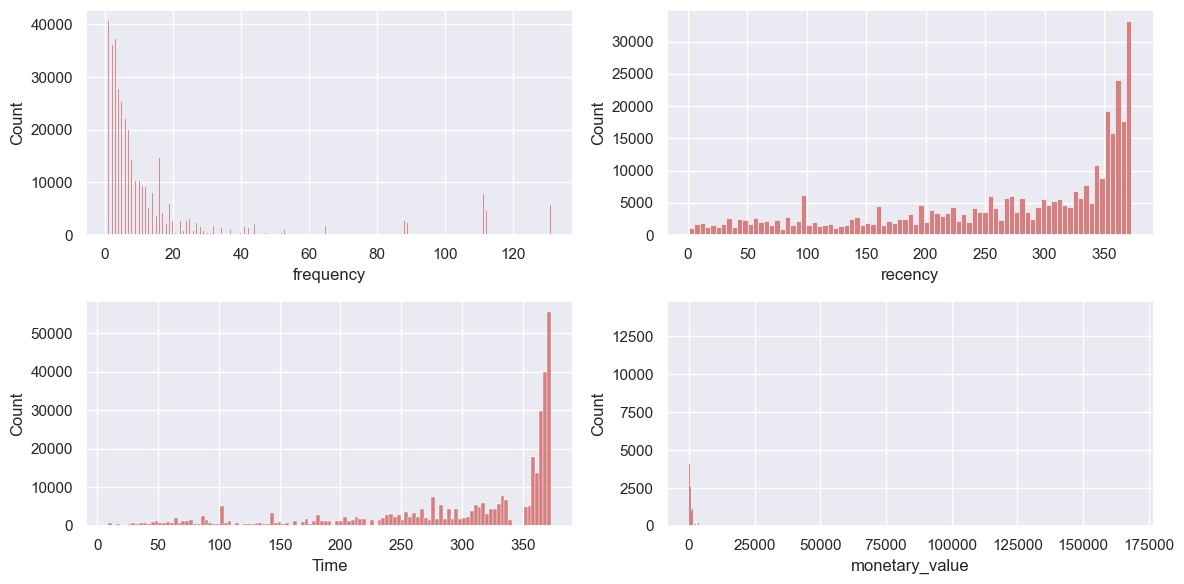

In [62]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(['frequency','recency','Time','monetary_value']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

- All the columns are skewed
- Applying a power transform featurewise to make data more Gaussian-like

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transfor

**What is Skewness?**
- Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zerom.

In [63]:
continuous_features

['frequency', 'recency', 'Time', 'monetary_value', 'CLV']

In [64]:
# Remove 'CLV' from continuous_features
continuous_features = [col for col in continuous_features if col != 'CLV']

# Check the skewness of the remaining continuous features
X[continuous_features].skew(axis=0, skipna=True)


frequency          3.045861
recency           -0.858016
Time              -1.300040
monetary_value    35.909875
dtype: float64

- Positiviely Skewed : frequency, monetary_value- Negatively Skewed : recency, Time


We can handle outliers and then check the skewness.

#### Apply Power Transformer to Check if it can reduces the outliers

In [65]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson')
transform_features = ['frequency', 'recency', 'Time', 'monetary_value']
X_copy = pt.fit_transform(X[transform_features])

In [66]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

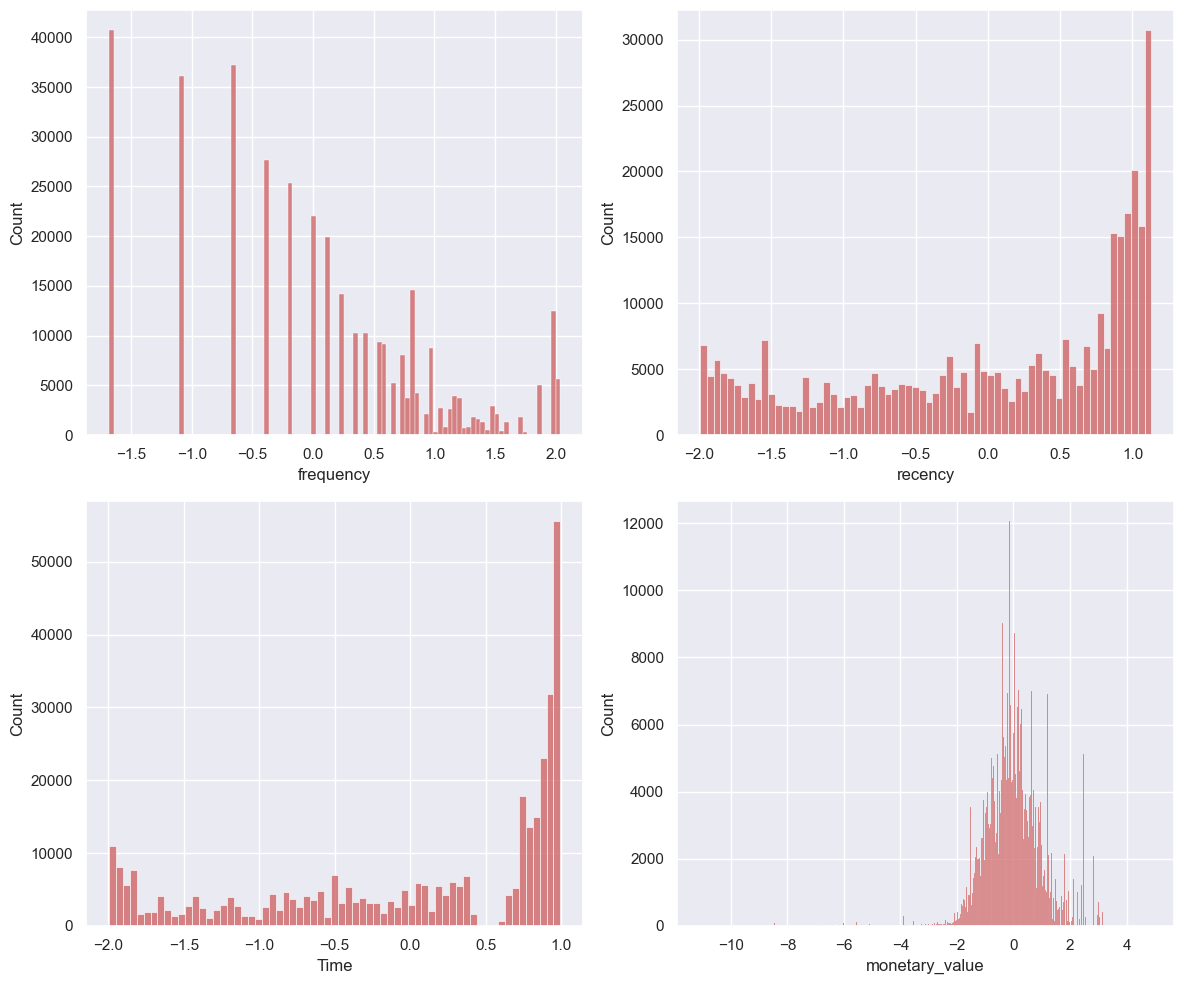

In [67]:
# Number of features to plot
num_features = len(transform_features)

# Calculate the number of rows needed
num_rows = (num_features + 1) // 2  # This ensures that we round up when needed

plt.figure(figsize=(12, 5 * num_rows))  # Adjust figure height based on number of rows

for i, col in enumerate(transform_features):
    plt.subplot(num_rows, 2, i + 1)  # Adjust the subplot to have enough rows
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [68]:
X_copy.skew(axis=0, skipna=True)

frequency         0.077511
recency          -0.573851
Time             -0.688332
monetary_value   -0.128374
dtype: float64

### Understanding the Skewness Values:
1. **`frequency: 0.077511`**: 
   - This value is close to **0**, indicating that the distribution of `frequency` is approximately symmetric. It suggests that the transformation was effective in normalizing the distribution.

2. **`recency: -0.573851`**: 
   - This value indicates a moderate **negative skew**. The distribution has a longer left tail. Although it's better than being highly skewed, there's still some negative skewness present.

3. **`Time: -0.688332`**: 
   - Similar to `recency`, this indicates a moderate negative skew. Again, it's an improvement, but not perfectly normal.

4. **`monetary_value: -0.128374`**: 
   - This value is also close to **0**, indicating that the `monetary_value` distribution is near symmetric, suggesting effective normalization.

### Interpretation:
- **General Impact**: The Yeo-Johnson transformation has helped reduce the skewness of the features. While some features like `frequency` and `monetary_value` are now nearly symmetric, `recency` and `Time` still exhibit some skewness but are significantly improved from their original values.

### 3.3 Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

- One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**
-  Ordinal encoding is used here as label encoder is supported for column transformer- .
- ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between valu

**Standard Scaler**

- Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
- Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.es.

In [69]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [70]:
num_features

['frequency', 'recency', 'Time', 'monetary_value']

#### Preprocessing using ColumnTransformer

In [72]:
num_features

['frequency', 'recency', 'Time', 'monetary_value']

In [73]:
cat_features

['Description', 'Country']

In [74]:
# Create Column Transformer with 3 types of transformers
oh_columns = ['Description', 'Country']
transform_columns = ['frequency', 'recency', 'Time', 'monetary_value']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [75]:
X = preprocessor.fit_transform(X)

In [76]:
X

<361882x3880 sparse matrix of type '<class 'numpy.float64'>'
	with 3618820 stored elements in Compressed Sparse Row format>

In [77]:
X.shape

(361882, 3880)

### 3.4 Model Building

**train_test_split**
- The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.
- It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [79]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((289505, 3880), (72377, 3880))

In [81]:
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

**Create an Evaluate Function to give all metrics after model training**

In [82]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [83]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]


for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')
    

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 49.1492
- Mean Absolute Error: 25.0190
- R2 Score: 0.8536
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 44.1114
- Mean Absolute Error: 25.2432
- R2 Score: 0.8825


Lasso
Model performance for Training set
- Root Mean Squared Error: 55.6064
- Mean Absolute Error: 28.2416
- R2 Score: 0.8127
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 48.9618
- Mean Absolute Error: 28.1241
- R2 Score: 0.8552


Ridge
Model performance for Training set
- Root Mean Squared Error: 49.7995
- Mean Absolute Error: 25.7219
- R2 Score: 0.8497
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 45.1765
- Mean Absolute Error: 25.9098
- R2 Score: 0.8767


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 6.5957
- Mean Absolute Error: 2.0886
- R2 Score: 0.9974
-----------

In [84]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
4,Decision Tree,1.000000
5,Random Forest Regressor,1.000000
7,CatBoosting Regressor,0.999999
6,XGBRegressor,0.999998
3,K-Neighbors Regressor,0.996293
8,AdaBoost Regressor,0.956892
0,Linear Regression,0.882461
2,Ridge,0.876717
1,Lasso,0.855191


### The top 3 models are Decision Tree Regressor, Random Forest Regressor, and CatBoosting Regressor

In [90]:
d_tree_model = DecisionTreeRegressor()
d_tree_model = d_tree_model.fit(X_train, y_train)
y_pred = d_tree_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 100.00


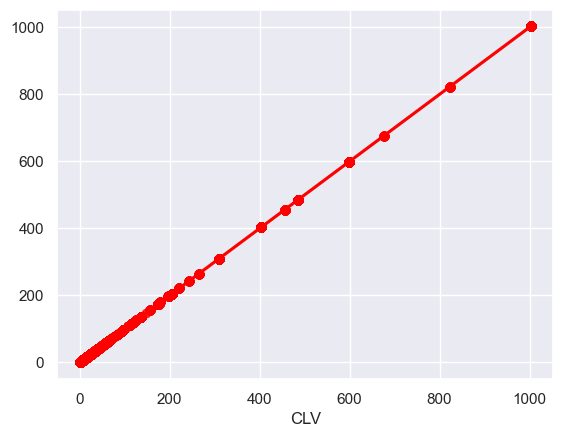

In [91]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');